In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import optuna
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

from counterfactuals import get_counterfactuals, objective
from cost_functions import wachter2017_cost_function, weighted_watcher_cost_function
warnings.filterwarnings('ignore')

from prefrences import Feature, get_constant_weight_function, get_pow_weight_function

import scipy.stats

In [148]:
pip install -U scikit-learn                                                                   

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Note: you may need to restart the kernel to use updated packages.


# Data reading and visualization

In [40]:
df = pd.read_csv('../datasets/adult.csv', na_values='?', index_col=0)

In [41]:
df.to_csv('adult.csv', index=False)

In [39]:
df.index

RangeIndex(start=0, stop=48842, step=1)

In [42]:
df.isnull().sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [43]:
# drop rows with missing vals
df = df.dropna()

In [44]:
df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

### Target class distribution

In [45]:
target = df.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Percentage=%.3f%%' % (k, per))

Class=<=50K, Percentage=75.216%
Class=>50K, Percentage=24.784%


### Select columns with numerical data types

In [46]:
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
subset = df[num_ix]

In [47]:
subset.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
0,25,226802,7,0,0,40
1,38,89814,9,0,0,50
2,28,336951,12,0,0,40
3,44,160323,10,7688,0,40
5,34,198693,6,0,0,30


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'educational-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

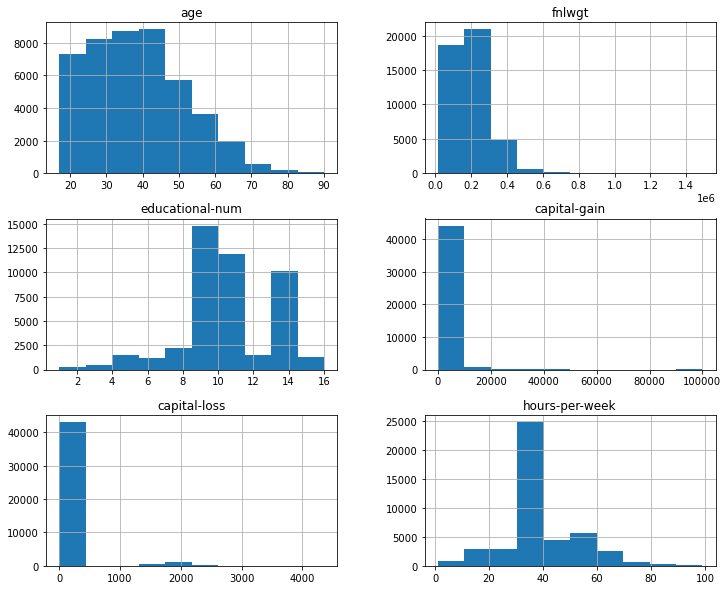

In [48]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
subset.hist(ax=ax)

In [49]:
cat_ix = df.select_dtypes(include=['object', 'bool']).columns

### Train/Test split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['income']), df['income'],
                                   random_state=42, 
                                   test_size=0.2, 
                                   shuffle=True)

In [51]:
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%s, Percentage=%.3f%%' % (k, per))

Class=>50K, Percentage=24.892%
Class=<=50K, Percentage=75.108%


### Model

In [52]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, verbose=1)

In [53]:
def process_dataset(df):
    df = df.dropna()
     # split into inputs and outputs
    X = df.drop(columns=['income'])
    y = df['income']
    # select categorical and numerical features
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y, cat_ix, num_ix

In [57]:
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
# define the pipeline
pipeline = Pipeline(steps=[('t',ct), ('m',gbc)])

In [58]:
X, y, cat_ix, num_ix = process_dataset(df)

In [59]:
pipeline.fit(X,y)

      Iter       Train Loss   Remaining Time 
         1           1.0484           23.03s
         2           0.9947           20.99s
         3           0.9524           20.14s
         4           0.9166           19.44s
         5           0.8873           19.23s
         6           0.8617           19.24s
         7           0.8397           18.89s
         8           0.8214           19.04s
         9           0.8050           18.85s
        10           0.7894           18.48s
        20           0.7052           17.10s
        30           0.6645           15.89s
        40           0.6419           14.69s
        50           0.6267           13.66s
        60           0.6153           12.61s
        70           0.6065           11.65s
        80           0.5991           10.68s
        90           0.5943            9.74s
       100           0.5893            8.82s
       200           0.5630            0.00s


Pipeline(steps=[('t',
                 ColumnTransformer(transformers=[('c', OneHotEncoder(),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')),
                                                 ('n', MinMaxScaler(),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object'))])),
                ('m', GradientBoostingClassifier(n_estimators=200, verbose=1))])

In [69]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [26]:
x=X.loc[15].values
x = x.reshape((1, -1))
sample_df = pd.DataFrame(x, columns=X.columns )

In [27]:
sample_df

,Unnamed: 0,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,15,43,Private,346189,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States


In [60]:
pipeline.predict_proba(sample_df)

array([[0.11495593, 0.88504407]])

### Model evaluation

In [61]:
X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


In [29]:
y_test = LabelEncoder().fit_transform(y_test)
y_train = LabelEncoder().fit_transform(y_train)

In [30]:
accuracy_score(pipeline.predict(X_test), y_test)

0.876285240464345

In [31]:
accuracy_score(pipeline.predict(X_train), y_train)

0.8716035049893579

In [62]:
with open('pretrained_models/pipeline_adult.pkl','wb') as f:
    pickle.dump(pipeline,f)

In [35]:
pipeline.predict(X)

array([0, 0, 0, ..., 0, 0, 1])

#### F score

# Get counterfactuals

In [76]:
sample_df[num_ix].values

array([[43, 346189, 14, 0, 0, 50]], dtype=object)

In [77]:
np.sum(sample_df[num_ix].values-sample_df[num_ix].values)

0

In [78]:
 pipeline.predict_proba(sample_df)

array([[0.11495593, 0.88504407]])

In [79]:
def wachter2017_cost_function_ignore_categorical(x_prime: np.ndarray, x: np.ndarray, y_prime, lambda_value: float, model: object, X) -> float:
    mad =  scipy.stats.median_abs_deviation(X[num_ix], axis=0)
    distance = np.sum(np.abs(x[num_ix].values-x_prime[num_ix].values)/(mad+1))
    prediction = model.predict_proba(x_prime)[0][0]
    misfit = (prediction-y_prime)**2
    return lambda_value * misfit + distance

In [80]:
wachter2017_cost_function_ignore_categorical(sample_df, sample_df, 0.2, 1, pipeline, X)

0.007232493661728958

In [83]:
#todo: new cost function where we treat categorical features: 1. exclude them 2. or? 

In [104]:
sample = X.loc[0]

In [108]:
sample.values[0]

25

In [109]:
P_prime = 0.1

features = []
features.append(Feature('age', float, (sample.values[0], sample.values[0]+10), get_pow_weight_function(sample.values[0], sample.values[0]+10, 20, 1000)))
    # features.append(Feature('Age', float, (x_example.values[-1], x_example.values[-1]+10), get_constant_weight_function(1)))



In [121]:
counterfactuals = get_counterfactuals(sample.values, P_prime, pipeline, X, 
                                          cost_function= wachter2017_cost_function_ignore_categorical, tol=0.1, 
                                          features=features, optimization_method="optuna", optimization_steps=20)

[W 2023-03-29 11:53:36,969] Trial 0 failed because of the following error: TypeError('wachter2017_cost_function_ignore_categorical() takes 6 positional arguments but 7 were given')
Traceback (most recent call last):
  File "C:\Users\katja\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\katja\OneDrive\Skrivebord\vaar2023\XAI\counterfactuals\XAI\XAI-CFE\counterfactuals.py", line 32, in <lambda>
    study.optimize(lambda trial: objective(trial, *objective_arguments), n_trials=optimization_steps)
  File "C:\Users\katja\OneDrive\Skrivebord\vaar2023\XAI\counterfactuals\XAI\XAI-CFE\counterfactuals.py", line 15, in objective
    return cost_function(x_prime, x, y_prime_target, lambda_k, model, X, weight_functions)
TypeError: wachter2017_cost_function_ignore_categorical() takes 6 positional arguments but 7 were given


TypeError: wachter2017_cost_function_ignore_categorical() takes 6 positional arguments but 7 were given

In [113]:
 study = optuna.create_study(direction='minimize')
            

In [131]:
objective_arguments = sample,0.2, 1, pipeline, X,  wachter2017_cost_function_ignore_categorical, features

In [133]:
study.optimize(lambda trial: objective(trial, *objective_arguments), n_trials=1)

[W 2023-03-29 11:57:22,314] Trial 8 failed because of the following error: TypeError('wachter2017_cost_function_ignore_categorical() takes 6 positional arguments but 7 were given')
Traceback (most recent call last):
  File "C:\Users\katja\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\katja\AppData\Local\Temp\ipykernel_23284\2999755795.py", line 1, in <lambda>
    study.optimize(lambda trial: objective(trial, *objective_arguments), n_trials=1)
  File "C:\Users\katja\OneDrive\Skrivebord\vaar2023\XAI\counterfactuals\XAI\XAI-CFE\counterfactuals.py", line 15, in objective
    return cost_function(x_prime, x, y_prime_target, lambda_k, model, X, weight_functions)
TypeError: wachter2017_cost_function_ignore_categorical() takes 6 positional arguments but 7 were given


TypeError: wachter2017_cost_function_ignore_categorical() takes 6 positional arguments but 7 were given